In [1]:
import os
import random
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt


# ============================================================
# 0) Reproducibility
# ============================================================
def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# ============================================================
# 1) Config (Trial12: Trial9 + dvce smoothing + last-k pooling)
# ============================================================
@dataclass
class Config:
    data_dir: str = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"
    out_dir: str = r"./Trial12"   # ✅ Trial12로 변경

    # seeds to sweep
    seeds: Tuple[int, ...] = (9819123, 111, 222, 333, 444)

    # sliding window
    seq_len: int = 100
    stride: int = 5
    pred_horizon: int = 0

    # split by FILE
    train_ratio: float = 0.7
    val_ratio: float = 0.2
    test_ratio: float = 0.1

    # training
    batch_size: int = 512
    epochs: int = 300
    lr: float = 1e-3
    weight_decay: float = 0.0
    patience: int = 30
    grad_clip: float = 1.0

    # model
    hidden_size: int = 512
    num_layers: int = 2
    dropout: float = 0.2

    # ✅ Trial12: last-k pooling
    last_k_pool: int = 20  # head input = mean(out[:, -k:, :])

    # ✅ Trial12: dvce smoothing / robust difference params
    dvce_ma_window: int = 5   # MA window size (causal)
    dvce_lag: int = 5         # dv[t] = MA[t] - MA[t-lag]

    # output controls
    save_figures: bool = True
    max_files_to_plot: Optional[int] = None  # None=all
    num_workers: int = 0

    # ===========================
    # Trial9: Evaluation settings
    # ===========================
    alpha: float = 0.20
    ph_consecutive_m: int = 5
    rep_method: str = "mean"

    lambdas: Tuple[float, ...] = (0.2, 0.4, 0.6, 0.8)
    lambda_to_plot: float = 0.6

    eps_rul: float = 1e-8


# ============================================================
# 2) Data utils
# ============================================================
def list_csv_files(data_dir: str) -> List[Path]:
    p = Path(data_dir)
    files = sorted([f for f in p.glob("*.csv") if f.is_file()])
    if len(files) == 0:
        raise FileNotFoundError(f"No CSV files found in: {data_dir}")
    return files


def read_one_csv(csv_path: Path) -> Tuple[np.ndarray, np.ndarray]:
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 2:
        raise ValueError(f"{csv_path.name}: expected at least 2 columns, got {df.shape[1]}")
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()

    if len(vce) != len(rul):
        raise ValueError(f"{csv_path.name}: length mismatch vce={len(vce)}, rul={len(rul)}")
    if len(vce) < 5:
        raise ValueError(f"{csv_path.name}: too short sequence length={len(vce)}")
    return vce, rul


def split_files(
    files: List[Path],
    train_ratio: float,
    val_ratio: float,
    test_ratio: float,
    seed: int
) -> Dict[str, List[Path]]:
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    rng = random.Random(seed)
    files_shuffled = files[:]
    rng.shuffle(files_shuffled)

    n = len(files_shuffled)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train_files = files_shuffled[:n_train]
    val_files = files_shuffled[n_train:n_train + n_val]
    test_files = files_shuffled[n_train + n_val:]

    return {"train": train_files, "val": val_files, "test": test_files}


def causal_moving_average(x: np.ndarray, window: int) -> np.ndarray:
    """
    Causal MA: ma[t] = mean(x[max(0,t-window+1):t+1])
    Leakage 없이 현재/과거만 사용.
    """
    if window <= 1:
        return x.astype(np.float32)

    x = x.astype(np.float32)
    csum = np.cumsum(x, dtype=np.float64)
    out = np.empty_like(x, dtype=np.float32)
    for t in range(len(x)):
        s = max(0, t - window + 1)
        tot = csum[t] - (csum[s - 1] if s > 0 else 0.0)
        out[t] = float(tot / (t - s + 1))
    return out


def compute_dvce_smooth(vce: np.ndarray, ma_window: int, lag: int) -> np.ndarray:
    """
    ✅ Trial12 robust dvce:
      ma = causal MA(vce)
      dv[t] = ma[t] - ma[t-lag]   (t<lag -> 0)
    """
    ma = causal_moving_average(vce, ma_window)
    dv = np.zeros_like(ma, dtype=np.float32)
    if lag <= 0:
        # fallback: first difference on MA (still smoother than raw)
        dv[1:] = ma[1:] - ma[:-1]
        return dv

    dv[lag:] = ma[lag:] - ma[:-lag]
    return dv


# ============================================================
# 3) Dataset
# ============================================================
class WindowedRULDatasetNorm2F(Dataset):
    def __init__(
        self,
        file_list: List[Path],
        seq_len: int,
        stride: int,
        pred_horizon: int,
        scaler_x: StandardScaler = None,
        fit_scaler: bool = False,
        # ✅ Trial12: dvce smoothing params
        dvce_ma_window: int = 5,
        dvce_lag: int = 5,
    ):
        self.file_list = file_list
        self.seq_len = seq_len
        self.stride = stride
        self.pred_horizon = pred_horizon
        self.scaler_x = scaler_x if scaler_x is not None else StandardScaler()
        self.dvce_ma_window = dvce_ma_window
        self.dvce_lag = dvce_lag

        # store: (name, X2(T,2), rul(T,), rul0)
        self.series: List[Tuple[str, np.ndarray, np.ndarray, float]] = []
        for fp in self.file_list:
            vce, rul = read_one_csv(fp)
            rul0 = float(rul[0])
            if rul0 <= 0:
                raise ValueError(f"{fp.name}: RUL0 must be > 0, got {rul0}")

            dv = compute_dvce_smooth(vce, ma_window=self.dvce_ma_window, lag=self.dvce_lag)
            x2 = np.stack([vce.astype(np.float32), dv.astype(np.float32)], axis=1).astype(np.float32)  # (T,2)
            self.series.append((fp.name, x2, rul.astype(np.float32), rul0))

        if fit_scaler:
            all_x = np.concatenate([x2 for _, x2, _, _ in self.series], axis=0)
            self.scaler_x.fit(all_x)

        # window index
        self.index: List[Tuple[int, int]] = []
        for fi, (_name, x2, _rul, _rul0) in enumerate(self.series):
            T = x2.shape[0]
            last_start = T - (seq_len + pred_horizon)
            if last_start < 0:
                continue
            for s in range(0, last_start + 1, stride):
                self.index.append((fi, s))

        if len(self.index) == 0:
            raise ValueError("No windows were created. Check seq_len/pred_horizon vs file lengths.")

    def __len__(self) -> int:
        return len(self.index)

    def __getitem__(self, idx: int):
        fi, s = self.index[idx]
        name, x2, rul, rul0 = self.series[fi]

        x = x2[s:s + self.seq_len, :]
        y_idx = s + self.seq_len - 1 + self.pred_horizon
        y_cycles = float(rul[y_idx])
        y_norm = np.array([y_cycles / rul0], dtype=np.float32)

        x = self.scaler_x.transform(x).astype(np.float32)

        return (
            torch.from_numpy(x),
            torch.from_numpy(y_norm),
            name,
            torch.tensor(s, dtype=torch.long),
            torch.tensor(y_cycles, dtype=torch.float32),
            torch.tensor(rul0, dtype=torch.float32),
        )


# ============================================================
# 4) Model (Trial12: last-k pooling)
# ============================================================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float, last_k_pool: int = 20):
        super().__init__()
        self.last_k_pool = int(last_k_pool)

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)  # (B,T,H)
        k = self.last_k_pool
        if k is None or k <= 1:
            pooled = out[:, -1, :]
        else:
            k = min(k, out.shape[1])
            pooled = out[:, -k:, :].mean(dim=1)  # ✅ last-k pooling
        return self.head(pooled)


# ============================================================
# 5) Basic Eval + Save window-level predictions
# ============================================================
@torch.no_grad()
def evaluate_basic(model, loader, device) -> Dict[str, float]:
    model.eval()

    mae_norm_list, mse_norm_list = [], []
    mae_cyc_list, mse_cyc_list = [], []

    for x, y_norm, _name, _s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)

        err_norm = pred_norm - y_norm
        mae_norm_list.append(torch.mean(torch.abs(err_norm)).item())
        mse_norm_list.append(torch.mean(err_norm ** 2).item())

        pred_cycles = pred_norm * rul0
        err_cyc = pred_cycles - y_cycles
        mae_cyc_list.append(torch.mean(torch.abs(err_cyc)).item())
        mse_cyc_list.append(torch.mean(err_cyc ** 2).item())

    return {
        "mae_norm": float(np.mean(mae_norm_list)) if mae_norm_list else float("nan"),
        "rmse_norm": float(np.sqrt(np.mean(mse_norm_list))) if mse_norm_list else float("nan"),
        "mae_cycles": float(np.mean(mae_cyc_list)) if mae_cyc_list else float("nan"),
        "rmse_cycles": float(np.sqrt(np.mean(mse_cyc_list))) if mse_cyc_list else float("nan"),
    }


@torch.no_grad()
def save_predictions_windows_csv(model, loader, device, out_csv: str, seq_len: int) -> None:
    model.eval()
    rows: List[Dict[str, Any]] = []

    for x, y_norm, name, s, y_cycles, rul0 in loader:
        x = x.to(device)
        y_norm = y_norm.to(device)
        y_cycles = y_cycles.to(device).view(-1, 1)
        rul0 = rul0.to(device).view(-1, 1)

        pred_norm = model(x)
        pred_cycles = pred_norm * rul0

        pred_norm_np = pred_norm.cpu().numpy().reshape(-1)
        y_norm_np = y_norm.cpu().numpy().reshape(-1)
        pred_cyc_np = pred_cycles.cpu().numpy().reshape(-1)
        y_cyc_np = y_cycles.cpu().numpy().reshape(-1)

        rul0_np = rul0.cpu().numpy().reshape(-1)
        s_np = s.cpu().numpy().reshape(-1)
        name_list = list(name)

        for i in range(len(pred_norm_np)):
            rows.append({
                "file": name_list[i],
                "start_idx": int(s_np[i]),
                "cycle": int(s_np[i] + (seq_len - 1)),
                "rul0": float(rul0_np[i]),
                "RUL_true": float(y_cyc_np[i]),
                "RUL_pred": float(pred_cyc_np[i]),
                "RUL_true_norm": float(y_norm_np[i]),
                "RUL_pred_norm": float(pred_norm_np[i]),
            })

    pd.DataFrame(rows).to_csv(out_csv, index=False)


# ============================================================
# 6) Window -> Cycle sequence (mean representative)
# ============================================================
def windows_to_cycle_sequence_mean(windows_csv: str) -> pd.DataFrame:
    dfw = pd.read_csv(windows_csv)
    if dfw.empty:
        raise ValueError(f"Empty windows csv: {windows_csv}")

    g = dfw.groupby(["file", "cycle"], as_index=False).agg(
        rul0=("rul0", "first"),
        RUL_true=("RUL_true", "mean"),
        RUL_pred=("RUL_pred", "mean"),
        n_windows=("RUL_pred", "count"),
    )
    return g


# ============================================================
# 7) Prognostics metrics: Relative Error / RA / CRA / PH / α–λ / Convergence
# ============================================================
def compute_metrics_for_one_file(
    df_seq_one_file: pd.DataFrame,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
) -> Tuple[pd.DataFrame, Dict[str, Any]]:
    df = df_seq_one_file.sort_values("cycle").reset_index(drop=True).copy()

    t_s = seq_len - 1
    last_cycle = int(df["cycle"].max())
    EOL_true = last_cycle + 1
    t_e = EOL_true - 1

    df_eval = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df_eval.reset_index(drop=True, inplace=True)

    if df_eval.empty:
        summary = {
            "t_s": t_s, "t_e": t_e, "EOL_true": EOL_true,
            "PH": np.nan, "t_PH_start": np.nan,
            "CRA": np.nan, "Convergence_cycles": np.nan,
        }
        for lam in lambdas:
            summary[f"t_lambda_{lam:.2f}"] = np.nan
            summary[f"alpha_lambda_ok_{lam:.2f}"] = np.nan
        return df_eval, summary

    denom = np.maximum(np.abs(df_eval["RUL_true"].values), eps_rul)
    rel_err = np.abs(df_eval["RUL_true"].values - df_eval["RUL_pred"].values) / denom
    RA = 1.0 - rel_err

    df_eval["rel_err"] = rel_err
    df_eval["RA"] = RA
    df_eval["in_alpha"] = df_eval["rel_err"] <= alpha

    CRA = float(np.mean(df_eval["RA"].values))

    flags = df_eval["in_alpha"].values.astype(np.int32)
    t_PH_start = np.nan
    if len(flags) >= ph_consecutive_m:
        run = 0
        for i, ok in enumerate(flags):
            if ok:
                run += 1
                if run >= ph_consecutive_m:
                    start_i = i - ph_consecutive_m + 1
                    t_PH_start = int(df_eval.loc[start_i, "cycle"])
                    break
            else:
                run = 0

    if np.isfinite(t_PH_start):
        PH = float(EOL_true - t_PH_start)
        Convergence_cycles = float(t_PH_start - t_s)
    else:
        PH = np.nan
        Convergence_cycles = np.nan

    rul0 = float(df_eval["rul0"].iloc[0])
    lam_results = {}
    for lam in lambdas:
        target_rul = (1.0 - float(lam)) * rul0
        idx = int(np.argmin(np.abs(df_eval["RUL_true"].values - target_rul)))
        t_lam = int(df_eval.loc[idx, "cycle"])
        ok = bool(df_eval.loc[idx, "rel_err"] <= alpha)

        lam_results[f"t_lambda_{lam:.2f}"] = t_lam
        lam_results[f"alpha_lambda_ok_{lam:.2f}"] = int(ok)

    summary = {
        "t_s": int(t_s),
        "t_e": int(t_e),
        "EOL_true": int(EOL_true),
        "alpha": float(alpha),
        "ph_consecutive_m": int(ph_consecutive_m),
        "CRA": CRA,
        "t_PH_start": t_PH_start if np.isfinite(t_PH_start) else np.nan,
        "PH": PH,
        "Convergence_cycles": Convergence_cycles,
        **lam_results
    }
    return df_eval, summary


def compute_metrics_from_windows_csv(
    windows_csv: str,
    seq_len: int,
    alpha: float,
    ph_consecutive_m: int,
    lambdas: Tuple[float, ...],
    eps_rul: float,
    out_dir: str,
    split_name: str,
) -> Tuple[str, str]:
    os.makedirs(out_dir, exist_ok=True)

    df_seq = windows_to_cycle_sequence_mean(windows_csv)
    seq_path = os.path.join(out_dir, f"{split_name}_cycle_sequence_mean.csv")
    df_seq.to_csv(seq_path, index=False)

    rows = []
    for f in df_seq["file"].unique():
        sub = df_seq[df_seq["file"] == f].copy()
        _df_eval, summary = compute_metrics_for_one_file(
            df_seq_one_file=sub,
            seq_len=seq_len,
            alpha=alpha,
            ph_consecutive_m=ph_consecutive_m,
            lambdas=lambdas,
            eps_rul=eps_rul,
        )
        summary["file"] = f
        rows.append(summary)

    dfm = pd.DataFrame(rows)
    metrics_path = os.path.join(out_dir, f"{split_name}_prognostics_metrics_per_file.csv")
    dfm.to_csv(metrics_path, index=False)

    return seq_path, metrics_path


# ============================================================
# 8) Plotters (2 figures)
# ============================================================
def _safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def plot_alpha_ph(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    PH_start: Optional[float],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    plt.figure()

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")
    plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} alpha accuracy zone")
    plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} alpha accuracy zone")

    if PH_start is not None and np.isfinite(PH_start):
        plt.axvline(int(PH_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda(
    df_eval: pd.DataFrame,
    file_name: str,
    title: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    dpi: int = 200,
) -> None:
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].values
    y_true = df_eval["RUL_true"].values
    y_pred = df_eval["RUL_pred"].values

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, color="k", label="True (cycles)")
    plt.plot(x, y_pred, color="r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, linestyle=":", color="g", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], color="b", linestyle="--",
                     label=f"+{alpha:.2f} alpha–lambda accuracy zone")
            plt.plot(x[mask], lower[mask], color="b", linestyle="--",
                     label=f"-{alpha:.2f} alpha–lambda accuracy zone")
        else:
            plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, color="b", linestyle="--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, color="b", linestyle="--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title}\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close()


def make_paper_figures_for_split(
    cycle_seq_csv: str,
    metrics_per_file_csv: str,
    out_fig_dir: str,
    title_prefix: str,
    alpha: float,
    lambda_to_plot: float,
    max_files: Optional[int] = None,
    dpi: int = 200,
) -> None:
    df_seq = pd.read_csv(cycle_seq_csv)
    dfm = pd.read_csv(metrics_per_file_csv)

    files = df_seq["file"].unique().tolist()
    if max_files is not None:
        files = files[:max_files]

    os.makedirs(out_fig_dir, exist_ok=True)
    lam_key = f"t_lambda_{lambda_to_plot:.2f}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].sort_values("cycle").copy()
        mrow = dfm[dfm["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        PH_start = mrow.get("t_PH_start", np.nan)

        df_eval = sub[(sub["cycle"] >= t_s) & (sub["cycle"] <= t_e)].copy()
        if df_eval.empty:
            continue

        t_lambda = None
        if lam_key in mrow and np.isfinite(mrow[lam_key]):
            t_lambda = int(mrow[lam_key])

        safe = _safe_name(f)

        out1 = os.path.join(out_fig_dir, f"FIG1_alpha_PH__{safe}.png")
        plot_alpha_ph(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α+PH",
            alpha=alpha,
            PH_start=PH_start if np.isfinite(PH_start) else None,
            out_path=out1,
            dpi=dpi,
        )

        out2 = os.path.join(out_fig_dir, f"FIG2_alpha_lambda__lam{lambda_to_plot:.2f}__{safe}.png")
        plot_alpha_lambda(
            df_eval=df_eval,
            file_name=f,
            title=f"{title_prefix} | α–λ (λ={lambda_to_plot:.2f})",
            alpha=alpha,
            lambda_to_plot=lambda_to_plot,
            t_lambda=t_lambda,
            out_path=out2,
            dpi=dpi,
        )


# ============================================================
# 9) One seed run (train + export best/last + metrics)
# ============================================================
def run_one_seed(cfg: Config, seed: int) -> Dict[str, Any]:
    set_seed(seed)

    seed_dir = os.path.join(cfg.out_dir, f"seed_{seed}")
    os.makedirs(seed_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\n==============================")
    print(f"[SEED {seed}] device={device}")
    print(f"[SEED {seed}] out={seed_dir}")
    print(f"==============================")

    files = list_csv_files(cfg.data_dir)
    splits = split_files(files, cfg.train_ratio, cfg.val_ratio, cfg.test_ratio, seed)

    for k in ["train", "val", "test"]:
        pd.Series([p.name for p in splits[k]]).to_csv(
            os.path.join(seed_dir, f"{k}_files.csv"), index=False, header=False
        )

    scaler_x = StandardScaler()
    train_ds = WindowedRULDatasetNorm2F(
        splits["train"], cfg.seq_len, cfg.stride, cfg.pred_horizon,
        scaler_x=scaler_x, fit_scaler=True,
        dvce_ma_window=cfg.dvce_ma_window, dvce_lag=cfg.dvce_lag
    )
    val_ds = WindowedRULDatasetNorm2F(
        splits["val"], cfg.seq_len, cfg.stride, cfg.pred_horizon,
        scaler_x=train_ds.scaler_x, fit_scaler=False,
        dvce_ma_window=cfg.dvce_ma_window, dvce_lag=cfg.dvce_lag
    )
    test_ds = WindowedRULDatasetNorm2F(
        splits["test"], cfg.seq_len, cfg.stride, cfg.pred_horizon,
        scaler_x=train_ds.scaler_x, fit_scaler=False,
        dvce_ma_window=cfg.dvce_ma_window, dvce_lag=cfg.dvce_lag
    )

    pd.DataFrame({
        "feature": ["min_vce", "d_min_vce_smooth"],
        "mean": train_ds.scaler_x.mean_.ravel(),
        "std": np.sqrt(train_ds.scaler_x.var_).ravel(),
        "dvce_ma_window": [cfg.dvce_ma_window, cfg.dvce_ma_window],
        "dvce_lag": [cfg.dvce_lag, cfg.dvce_lag],
    }).to_csv(os.path.join(seed_dir, "scaler_x_mean_std.csv"), index=False)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    train_eval = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    val_eval = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)
    test_eval = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    model = LSTMRegressor(
        input_size=2,
        hidden_size=cfg.hidden_size,
        num_layers=cfg.num_layers,
        dropout=cfg.dropout,
        last_k_pool=cfg.last_k_pool,
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

    best_by_val_norm = float("inf")
    best_path = os.path.join(seed_dir, "best_by_val_norm.pt")
    last_path = os.path.join(seed_dir, "last_epoch.pt")

    history: List[Dict[str, Any]] = []
    bad_epochs = 0

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        losses = []

        for x, y_norm, *_ in train_loader:
            x = x.to(device)
            y_norm = y_norm.to(device)

            optimizer.zero_grad()
            pred_norm = model(x)
            loss = criterion(pred_norm, y_norm)
            loss.backward()

            if cfg.grad_clip and cfg.grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)

            optimizer.step()
            losses.append(loss.item())

        train_mse_norm = float(np.mean(losses)) if losses else float("nan")
        val_metrics = evaluate_basic(model, val_loader, device)

        history.append({
            "epoch": epoch,
            "train_mse_norm": train_mse_norm,
            "val_rmse_norm": val_metrics["rmse_norm"],
            "val_mae_norm": val_metrics["mae_norm"],
            "val_rmse_cycles": val_metrics["rmse_cycles"],
            "val_mae_cycles": val_metrics["mae_cycles"],
        })

        if val_metrics["rmse_norm"] < best_by_val_norm:
            best_by_val_norm = val_metrics["rmse_norm"]
            bad_epochs = 0
            torch.save(model.state_dict(), best_path)
        else:
            bad_epochs += 1

        if epoch == 1 or epoch % 10 == 0:
            print(
                f"[SEED {seed}] [{epoch:03d}/{cfg.epochs}] "
                f"train_mse_norm={train_mse_norm:.6f} | "
                f"val_rmse_norm={val_metrics['rmse_norm']:.6f} | "
                f"val_mae_cycles={val_metrics['mae_cycles']:.3f} | "
                f"best_val_rmse_norm={best_by_val_norm:.6f}"
            )

        if bad_epochs >= cfg.patience:
            print(f"[SEED {seed}] Early stopping at epoch {epoch}.")
            break

    pd.DataFrame(history).to_csv(os.path.join(seed_dir, "history.csv"), index=False)
    torch.save(model.state_dict(), last_path)

    def export_ckpt(tag: str, ckpt_path: str) -> Dict[str, Any]:
        sub_dir = os.path.join(seed_dir, tag)
        os.makedirs(sub_dir, exist_ok=True)

        model.load_state_dict(torch.load(ckpt_path, map_location=device))
        model.eval()

        tr = evaluate_basic(model, train_eval, device)
        va = evaluate_basic(model, val_eval, device)
        te = evaluate_basic(model, test_eval, device)

        for split_name, loader in [("train", train_eval), ("val", val_eval), ("test", test_eval)]:
            win_csv = os.path.join(sub_dir, f"{split_name}_predictions_windows.csv")
            save_predictions_windows_csv(model, loader, device, win_csv, seq_len=cfg.seq_len)

            seq_csv, metrics_csv = compute_metrics_from_windows_csv(
                windows_csv=win_csv,
                seq_len=cfg.seq_len,
                alpha=cfg.alpha,
                ph_consecutive_m=cfg.ph_consecutive_m,
                lambdas=cfg.lambdas,
                eps_rul=cfg.eps_rul,
                out_dir=sub_dir,
                split_name=split_name,
            )

            if cfg.save_figures:
                fig_dir = os.path.join(sub_dir, "paper_figures", split_name)
                make_paper_figures_for_split(
                    cycle_seq_csv=seq_csv,
                    metrics_per_file_csv=metrics_csv,
                    out_fig_dir=fig_dir,
                    title_prefix=f"SEED {seed} | {tag.upper()} | {split_name} | Trial12",
                    alpha=cfg.alpha,
                    lambda_to_plot=cfg.lambda_to_plot,
                    max_files=cfg.max_files_to_plot,
                )

        ms = {
            "seed": seed,
            "checkpoint": tag,
            "train_rmse_cycles": tr["rmse_cycles"],
            "train_mae_cycles": tr["mae_cycles"],
            "train_rmse_norm": tr["rmse_norm"],
            "train_mae_norm": tr["mae_norm"],
            "val_rmse_cycles": va["rmse_cycles"],
            "val_mae_cycles": va["mae_cycles"],
            "val_rmse_norm": va["rmse_norm"],
            "val_mae_norm": va["mae_norm"],
            "test_rmse_cycles": te["rmse_cycles"],
            "test_mae_cycles": te["mae_cycles"],
            "test_rmse_norm": te["rmse_norm"],
            "test_mae_norm": te["mae_norm"],
            "stopped_epoch": history[-1]["epoch"] if len(history) else None,
            "best_val_rmse_norm": best_by_val_norm,
            "alpha": cfg.alpha,
            "ph_consecutive_m": cfg.ph_consecutive_m,
            "rep_method": cfg.rep_method,
            "lambdas": str(cfg.lambdas),
            "lambda_to_plot": cfg.lambda_to_plot,
            "last_k_pool": cfg.last_k_pool,
            "dvce_ma_window": cfg.dvce_ma_window,
            "dvce_lag": cfg.dvce_lag,
        }
        pd.DataFrame([ms]).to_csv(os.path.join(sub_dir, "metrics_summary.csv"), index=False)

        print(f"[SEED {seed}] {tag}: TEST mae_cycles={te['mae_cycles']:.3f} | rmse_cycles={te['rmse_cycles']:.3f} | rmse_norm={te['rmse_norm']:.6f}")
        return ms

    ms_best = export_ckpt("best_by_val_norm", best_path)
    ms_last = export_ckpt("last_epoch", last_path)

    return {"seed": seed, "seed_dir": seed_dir, "best": ms_best, "last": ms_last}


# ============================================================
# 10) Seed sweep + global comparison
# ============================================================
def summarize_across_seeds(cfg: Config, results: List[Dict[str, Any]]) -> None:
    rows = []
    for r in results:
        rows.append(r["best"])
        rows.append(r["last"])

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(cfg.out_dir, "summary_across_seeds.csv"), index=False)

    def _isfinite(x: Any) -> bool:
        try:
            return bool(np.isfinite(float(x)))
        except Exception:
            return False

    def win_rate(metric: str) -> Dict[str, Any]:
        wins_last = 0
        wins_best = 0
        ties = 0
        diffs = []

        for r in results:
            b = r["best"][metric]
            l = r["last"][metric]
            if _isfinite(b) and _isfinite(l):
                diffs.append(float(l) - float(b))
                if float(l) < float(b):
                    wins_last += 1
                elif float(b) < float(l):
                    wins_best += 1
                else:
                    ties += 1

        return {
            "metric": metric,
            "wins_last": wins_last,
            "wins_best": wins_best,
            "ties": ties,
            "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
            "std(last-best)": float(np.std(diffs)) if diffs else float("nan"),
        }

    metrics = ["test_mae_cycles", "test_rmse_cycles", "test_mae_norm", "test_rmse_norm"]
    wr = [win_rate(m) for m in metrics]
    pd.DataFrame(wr).to_csv(os.path.join(cfg.out_dir, "win_rate_summary.csv"), index=False)

    lines = []
    lines.append("=== WIN-RATE SUMMARY (TEST; lower is better) ===")
    for row in wr:
        lines.append(
            f"- {row['metric']}: last wins={row['wins_last']}, best wins={row['wins_best']}, ties={row['ties']} | "
            f"mean(last-best)={row['mean(last-best)']:.6f}, std(last-best)={row['std(last-best)']:.6f}"
        )

    agg = df.groupby("checkpoint")[metrics].agg(["mean", "std"])
    lines.append("\n=== MEAN ± STD across seeds (TEST) ===")
    lines.append(str(agg))

    with open(os.path.join(cfg.out_dir, "win_rate_summary.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(lines))

    print("\n".join(lines))
    print("\nSaved:")
    print(" -", os.path.join(cfg.out_dir, "summary_across_seeds.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.csv"))
    print(" -", os.path.join(cfg.out_dir, "win_rate_summary.txt"))


def run_trial12_seed_sweep(cfg: Config) -> None:
    os.makedirs(cfg.out_dir, exist_ok=True)

    results = []
    for seed in cfg.seeds:
        res = run_one_seed(cfg, seed)
        results.append(res)

    summarize_across_seeds(cfg, results)

    print("\nDONE. Check Trial12 folder:")
    print(" - per seed results: Trial12/seed_<seed>/...")
    print(" - figures (paper-style): seed_<seed>/<ckpt>/paper_figures/<split>/")
    print(" - cycle sequence mean CSV: <ckpt>/<split>_cycle_sequence_mean.csv")
    print(" - PH/α–λ metrics CSV: <ckpt>/<split>_prognostics_metrics_per_file.csv")


# ============================================================
# 11) Run
# ============================================================
if __name__ == "__main__":
    cfg = Config(
        data_dir=r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100",
        out_dir=r"./Trial12",

        seeds=(9819123, 111, 222, 333, 444),

        seq_len=100,
        stride=5,
        pred_horizon=0,

        train_ratio=0.7,
        val_ratio=0.2,
        test_ratio=0.1,

        batch_size=512,
        epochs=300,
        lr=1e-3,
        weight_decay=0.0,
        patience=30,
        grad_clip=1.0,

        hidden_size=512,
        num_layers=2,
        dropout=0.2,

        # ✅ Trial12 knobs
        last_k_pool=20,
        dvce_ma_window=5,
        dvce_lag=5,

        save_figures=True,
        max_files_to_plot=None,
        num_workers=0,

        alpha=0.20,
        ph_consecutive_m=5,
        rep_method="mean",
        lambdas=(0.2, 0.4, 0.6, 0.8),
        lambda_to_plot=0.6,
    )

    run_trial12_seed_sweep(cfg)



[SEED 9819123] device=cuda
[SEED 9819123] out=./Trial12\seed_9819123
[SEED 9819123] [001/300] train_mse_norm=0.037195 | val_rmse_norm=0.168327 | val_mae_cycles=2313.958 | best_val_rmse_norm=0.168327
[SEED 9819123] [010/300] train_mse_norm=0.017193 | val_rmse_norm=0.160237 | val_mae_cycles=2236.971 | best_val_rmse_norm=0.156716
[SEED 9819123] [020/300] train_mse_norm=0.016542 | val_rmse_norm=0.159898 | val_mae_cycles=2190.030 | best_val_rmse_norm=0.156070
[SEED 9819123] [030/300] train_mse_norm=0.015623 | val_rmse_norm=0.159811 | val_mae_cycles=2185.266 | best_val_rmse_norm=0.156070
[SEED 9819123] [040/300] train_mse_norm=0.006460 | val_rmse_norm=0.174910 | val_mae_cycles=2316.268 | best_val_rmse_norm=0.156070
[SEED 9819123] Early stopping at epoch 42.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_55348\3332692613.py:784: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 9819123] best_by_val_norm: TEST mae_cycles=1145.277 | rmse_cycles=1648.851 | rmse_norm=0.113897


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_55348\3332692613.py:784: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 9819123] last_epoch: TEST mae_cycles=1348.384 | rmse_cycles=2030.520 | rmse_norm=0.137769

[SEED 111] device=cuda
[SEED 111] out=./Trial12\seed_111
[SEED 111] [001/300] train_mse_norm=0.044603 | val_rmse_norm=0.144347 | val_mae_cycles=2674.129 | best_val_rmse_norm=0.144347
[SEED 111] [010/300] train_mse_norm=0.018686 | val_rmse_norm=0.143380 | val_mae_cycles=2783.269 | best_val_rmse_norm=0.141782
[SEED 111] [020/300] train_mse_norm=0.017691 | val_rmse_norm=0.139825 | val_mae_cycles=2696.613 | best_val_rmse_norm=0.136842
[SEED 111] [030/300] train_mse_norm=0.017481 | val_rmse_norm=0.137595 | val_mae_cycles=2611.991 | best_val_rmse_norm=0.135146
[SEED 111] [040/300] train_mse_norm=0.015118 | val_rmse_norm=0.160148 | val_mae_cycles=3050.392 | best_val_rmse_norm=0.135146
[SEED 111] [050/300] train_mse_norm=0.003178 | val_rmse_norm=0.164575 | val_mae_cycles=3192.712 | best_val_rmse_norm=0.135146
[SEED 111] Early stopping at epoch 52.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_55348\3332692613.py:784: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 111] best_by_val_norm: TEST mae_cycles=1756.050 | rmse_cycles=2758.003 | rmse_norm=0.145836


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_55348\3332692613.py:784: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 111] last_epoch: TEST mae_cycles=1892.860 | rmse_cycles=3036.065 | rmse_norm=0.165161

[SEED 222] device=cuda
[SEED 222] out=./Trial12\seed_222
[SEED 222] [001/300] train_mse_norm=0.035482 | val_rmse_norm=0.157786 | val_mae_cycles=1749.332 | best_val_rmse_norm=0.157786
[SEED 222] [010/300] train_mse_norm=0.018678 | val_rmse_norm=0.138862 | val_mae_cycles=1542.725 | best_val_rmse_norm=0.138862
[SEED 222] [020/300] train_mse_norm=0.018176 | val_rmse_norm=0.137558 | val_mae_cycles=1543.917 | best_val_rmse_norm=0.137128
[SEED 222] [030/300] train_mse_norm=0.016003 | val_rmse_norm=0.146610 | val_mae_cycles=1572.141 | best_val_rmse_norm=0.137128
[SEED 222] [040/300] train_mse_norm=0.004161 | val_rmse_norm=0.171479 | val_mae_cycles=1763.326 | best_val_rmse_norm=0.137128
[SEED 222] Early stopping at epoch 44.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_55348\3332692613.py:784: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 222] best_by_val_norm: TEST mae_cycles=2127.980 | rmse_cycles=3080.341 | rmse_norm=0.127276


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_55348\3332692613.py:784: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 222] last_epoch: TEST mae_cycles=2524.869 | rmse_cycles=3736.116 | rmse_norm=0.156834

[SEED 333] device=cuda
[SEED 333] out=./Trial12\seed_333
[SEED 333] [001/300] train_mse_norm=0.038998 | val_rmse_norm=0.131317 | val_mae_cycles=1559.437 | best_val_rmse_norm=0.131317
[SEED 333] [010/300] train_mse_norm=0.019226 | val_rmse_norm=0.123491 | val_mae_cycles=1492.631 | best_val_rmse_norm=0.122642
[SEED 333] [020/300] train_mse_norm=0.018568 | val_rmse_norm=0.125220 | val_mae_cycles=1508.860 | best_val_rmse_norm=0.121050
[SEED 333] [030/300] train_mse_norm=0.015282 | val_rmse_norm=0.134721 | val_mae_cycles=1595.911 | best_val_rmse_norm=0.121050
[SEED 333] [040/300] train_mse_norm=0.002750 | val_rmse_norm=0.161771 | val_mae_cycles=1926.301 | best_val_rmse_norm=0.121050
[SEED 333] Early stopping at epoch 43.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_55348\3332692613.py:784: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 333] best_by_val_norm: TEST mae_cycles=975.492 | rmse_cycles=1563.467 | rmse_norm=0.145153


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_55348\3332692613.py:784: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 333] last_epoch: TEST mae_cycles=1000.572 | rmse_cycles=1688.126 | rmse_norm=0.163151

[SEED 444] device=cuda
[SEED 444] out=./Trial12\seed_444
[SEED 444] [001/300] train_mse_norm=0.037951 | val_rmse_norm=0.154871 | val_mae_cycles=2110.791 | best_val_rmse_norm=0.154871
[SEED 444] [010/300] train_mse_norm=0.017869 | val_rmse_norm=0.143869 | val_mae_cycles=2085.898 | best_val_rmse_norm=0.140337
[SEED 444] [020/300] train_mse_norm=0.017419 | val_rmse_norm=0.143148 | val_mae_cycles=2100.915 | best_val_rmse_norm=0.138707
[SEED 444] [030/300] train_mse_norm=0.015903 | val_rmse_norm=0.143042 | val_mae_cycles=2079.419 | best_val_rmse_norm=0.138707
[SEED 444] [040/300] train_mse_norm=0.003682 | val_rmse_norm=0.170817 | val_mae_cycles=2471.257 | best_val_rmse_norm=0.138707
[SEED 444] Early stopping at epoch 46.


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_55348\3332692613.py:784: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 444] best_by_val_norm: TEST mae_cycles=1461.894 | rmse_cycles=2095.544 | rmse_norm=0.142121


C:\Users\11HOME_AHCI\AppData\Local\Temp\ipykernel_55348\3332692613.py:784: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_loca

[SEED 444] last_epoch: TEST mae_cycles=1644.095 | rmse_cycles=2493.644 | rmse_norm=0.161851
=== WIN-RATE SUMMARY (TEST; lower is better) ===
- test_mae_cycles: last wins=0, best wins=5, ties=0 | mean(last-best)=188.817554, std(last-best)=120.877341
- test_rmse_cycles: last wins=0, best wins=5, ties=0 | mean(last-best)=367.652850, std(last-best)=173.902428
- test_mae_norm: last wins=0, best wins=5, ties=0 | mean(last-best)=0.012481, std(last-best)=0.003271
- test_rmse_norm: last wins=0, best wins=5, ties=0 | mean(last-best)=0.022097, std(last-best)=0.004217

=== MEAN ± STD across seeds (TEST) ===
                 test_mae_cycles             test_rmse_cycles              \
                            mean         std             mean         std   
checkpoint                                                                  
best_by_val_norm     1493.338609  464.243350       2229.24131  671.182331   
last_epoch           1682.156163  577.055242       2596.89416  813.633666   

           

In [3]:
import os
import numpy as np
import pandas as pd

# ============================
# Trial12 paths
# ============================
TRIAL12_DIR = "./Trial12"
SUMMARY_CSV = os.path.join(TRIAL12_DIR, "summary_across_seeds.csv")

BEST_TAG = "best_by_val_norm"
LAST_TAG = "last_epoch"


def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in summary CSV: {missing}")


def pick_best_row(df: pd.DataFrame, metric_prefix: str = "val") -> pd.Series:
    """
    metric_prefix: "val" or "test"
    Sort rule (lower is better):
      1) <prefix>_rmse_cycles ascending
      2) <prefix>_mae_cycles  ascending
    """
    rmse_col = f"{metric_prefix}_rmse_cycles"
    mae_col = f"{metric_prefix}_mae_cycles"
    _require_cols(df, ["seed", "checkpoint", rmse_col, mae_col])

    df_sorted = df.sort_values(
        by=[rmse_col, mae_col],
        ascending=[True, True]
    ).reset_index(drop=True)

    return df_sorted.iloc[0]


def win_rate(df: pd.DataFrame, metric: str) -> dict:
    """
    Compare BEST_TAG vs LAST_TAG within each seed on the given metric (lower is better).
    Returns wins for last, wins for best, ties, and mean(last-best).
    """
    _require_cols(df, ["seed", "checkpoint", metric])

    wins_last = 0
    wins_best = 0
    ties = 0
    diffs = []

    for seed, g in df.groupby("seed"):
        ckpts = set(g["checkpoint"].astype(str).values)
        if not ({BEST_TAG, LAST_TAG} <= ckpts):
            continue

        b = float(g.loc[g["checkpoint"] == BEST_TAG, metric].iloc[0])
        l = float(g.loc[g["checkpoint"] == LAST_TAG, metric].iloc[0])

        if np.isfinite(b) and np.isfinite(l):
            diffs.append(l - b)  # negative => last better
            if l < b:
                wins_last += 1
            elif b < l:
                wins_best += 1
            else:
                ties += 1

    return {
        "metric": metric,
        "wins_last": wins_last,
        "wins_best": wins_best,
        "ties": ties,
        "mean(last-best)": float(np.mean(diffs)) if diffs else float("nan"),
        "std(last-best)": float(np.std(diffs)) if diffs else float("nan"),
    }


def main():
    if not os.path.exists(SUMMARY_CSV):
        raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

    df = pd.read_csv(SUMMARY_CSV)

    # sanity check (Trial12 summary columns)
    needed = [
        "seed", "checkpoint",
        "train_rmse_cycles", "train_mae_cycles", "train_rmse_norm", "train_mae_norm",
        "val_rmse_cycles", "val_mae_cycles", "val_rmse_norm", "val_mae_norm",
        "test_rmse_cycles", "test_mae_cycles", "test_rmse_norm", "test_mae_norm",
    ]
    _require_cols(df, needed)

    # -----------------------------
    # 1) VAL 기준 best (권장)
    # -----------------------------
    best_val = pick_best_row(df, metric_prefix="val")
    best_val_seed = int(best_val["seed"])
    best_val_ckpt = str(best_val["checkpoint"])

    # -----------------------------
    # 2) TEST 기준 best (보고용)
    # -----------------------------
    best_test = pick_best_row(df, metric_prefix="test")
    best_test_seed = int(best_test["seed"])
    best_test_ckpt = str(best_test["checkpoint"])

    # -----------------------------
    # 3) win-rate (seed별 last vs best 비교)
    # -----------------------------
    wr_val_rmse = win_rate(df, "val_rmse_cycles")
    wr_test_rmse = win_rate(df, "test_rmse_cycles")
    wr_val_rmse_norm = win_rate(df, "val_rmse_norm")
    wr_test_rmse_norm = win_rate(df, "test_rmse_norm")

    # -----------------------------
    # 4) 출력
    # -----------------------------
    print("\n================ BEST MODEL (Trial12) ================")
    print("[SELECTED BY VAL]  (recommended for model selection)")
    print(f"  Seed             : {best_val_seed}")
    print(f"  Checkpoint       : {best_val_ckpt}")
    print(f"  VAL  RMSE (cyc)   : {best_val['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_val['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_val['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_val['val_mae_norm']:.6f}")
    print(f"  TEST RMSE (cyc)   : {best_val['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_val['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_val['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_val['test_mae_norm']:.6f}")

    print("\n[SELECTED BY TEST] (for reporting only; not for tuning)")
    print(f"  Seed             : {best_test_seed}")
    print(f"  Checkpoint       : {best_test_ckpt}")
    print(f"  TEST RMSE (cyc)   : {best_test['test_rmse_cycles']:.3f}")
    print(f"  TEST MAE  (cyc)   : {best_test['test_mae_cycles']:.3f}")
    print(f"  TEST RMSE (norm)  : {best_test['test_rmse_norm']:.6f}")
    print(f"  TEST MAE  (norm)  : {best_test['test_mae_norm']:.6f}")
    print(f"  VAL  RMSE (cyc)   : {best_test['val_rmse_cycles']:.3f}")
    print(f"  VAL  MAE  (cyc)   : {best_test['val_mae_cycles']:.3f}")
    print(f"  VAL  RMSE (norm)  : {best_test['val_rmse_norm']:.6f}")
    print(f"  VAL  MAE  (norm)  : {best_test['val_mae_norm']:.6f}")

    print("\n---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------")
    print(f"- {wr_val_rmse['metric']}: last wins={wr_val_rmse['wins_last']}, "
          f"best wins={wr_val_rmse['wins_best']}, ties={wr_val_rmse['ties']} | "
          f"mean(last-best)={wr_val_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse['metric']}: last wins={wr_test_rmse['wins_last']}, "
          f"best wins={wr_test_rmse['wins_best']}, ties={wr_test_rmse['ties']} | "
          f"mean(last-best)={wr_test_rmse['mean(last-best)']:.6f}")
    print(f"- {wr_val_rmse_norm['metric']}: last wins={wr_val_rmse_norm['wins_last']}, "
          f"best wins={wr_val_rmse_norm['wins_best']}, ties={wr_val_rmse_norm['ties']} | "
          f"mean(last-best)={wr_val_rmse_norm['mean(last-best)']:.6f}")
    print(f"- {wr_test_rmse_norm['metric']}: last wins={wr_test_rmse_norm['wins_last']}, "
          f"best wins={wr_test_rmse_norm['wins_best']}, ties={wr_test_rmse_norm['ties']} | "
          f"mean(last-best)={wr_test_rmse_norm['mean(last-best)']:.6f}")
    print("=====================================================\n")

    # -----------------------------
    # 5) 기록 저장 (VAL 기준 best)
    # -----------------------------
    out_txt = os.path.join(TRIAL12_DIR, "BEST_MODEL_BY_VAL.txt")
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write("BEST MODEL (Trial12) - Selected by VAL\n")
        f.write(f"seed={best_val_seed}\n")
        f.write(f"checkpoint={best_val_ckpt}\n")
        f.write(f"val_rmse_cycles={best_val['val_rmse_cycles']}\n")
        f.write(f"val_mae_cycles={best_val['val_mae_cycles']}\n")
        f.write(f"val_rmse_norm={best_val['val_rmse_norm']}\n")
        f.write(f"val_mae_norm={best_val['val_mae_norm']}\n")
        f.write(f"test_rmse_cycles={best_val['test_rmse_cycles']}\n")
        f.write(f"test_mae_cycles={best_val['test_mae_cycles']}\n")
        f.write(f"test_rmse_norm={best_val['test_rmse_norm']}\n")
        f.write(f"test_mae_norm={best_val['test_mae_norm']}\n")

        # (추가로 기록하면 실험 재현에 도움되는 Trial12 knobs)
        for k in ["last_k_pool", "dvce_ma_window", "dvce_lag", "stopped_epoch", "best_val_rmse_norm"]:
            if k in best_val.index:
                f.write(f"{k}={best_val[k]}\n")

    print(f"Saved -> {out_txt}")


if __name__ == "__main__":
    main()



================ BEST MODEL (Trial12) ================
[SELECTED BY VAL]  (recommended for model selection)
  Seed             : 333
  Checkpoint       : best_by_val_norm
  VAL  RMSE (cyc)   : 2129.574
  VAL  MAE  (cyc)   : 1452.357
  VAL  RMSE (norm)  : 0.121050
  VAL  MAE  (norm)  : 0.094400
  TEST RMSE (cyc)   : 1563.467
  TEST MAE  (cyc)   : 975.492
  TEST RMSE (norm)  : 0.145153
  TEST MAE  (norm)  : 0.115274

[SELECTED BY TEST] (for reporting only; not for tuning)
  Seed             : 333
  Checkpoint       : best_by_val_norm
  TEST RMSE (cyc)   : 1563.467
  TEST MAE  (cyc)   : 975.492
  TEST RMSE (norm)  : 0.145153
  TEST MAE  (norm)  : 0.115274
  VAL  RMSE (cyc)   : 2129.574
  VAL  MAE  (cyc)   : 1452.357
  VAL  RMSE (norm)  : 0.121050
  VAL  MAE  (norm)  : 0.094400

---------------- WIN-RATE (last_epoch vs best_by_val_norm) ----------------
- val_rmse_cycles: last wins=0, best wins=5, ties=0 | mean(last-best)=561.637136
- test_rmse_cycles: last wins=0, best wins=5, ties=0 | m

In [4]:
import os
import pandas as pd
import numpy as np

# =========================
# USER CONFIG (Trial12)
# =========================
TRIAL12_DIR = r"./Trial12"          # ✅ Trial12 루트 폴더
SEED = 333                          # 선택된 seed
CKPT = "best_by_val_norm"           # "best_by_val_norm" or "last_epoch"
SPLITS = ["train", "val", "test"]   # 평가할 split
LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]

# (선택) 후반 λ를 더 중요하게 보고 싶으면 가중치 사용
# 예: λ=0.2,0.4,0.6,0.8 가중치 = 1,1,2,3
LAMBDA_WEIGHTS = None  # 또는 {"0.20":1, "0.40":1, "0.60":2, "0.80":3}

# =========================
# Helpers
# =========================
def _require_cols(df: pd.DataFrame, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")


def compute_alpha_lambda_rates(dfm: pd.DataFrame, lam_strs, weights=None) -> dict:
    """
    dfm: <split>_prognostics_metrics_per_file.csv  (per-file summary)
    Returns:
      - per-lambda success rate (mean of alpha_lambda_ok_{lam})
      - overall mean rate (simple mean or weighted mean)
    """
    rates = {}

    for ls in lam_strs:
        col = f"alpha_lambda_ok_{ls}"
        if col in dfm.columns:
            # 0/1 평균 = 성공률
            rates[f"rate_{ls}"] = float(dfm[col].mean())
        else:
            rates[f"rate_{ls}"] = np.nan

    # overall score
    if weights is None:
        vals = [rates[f"rate_{ls}"] for ls in lam_strs if np.isfinite(rates[f"rate_{ls}"])]
        rates["rate_mean_all"] = float(np.mean(vals)) if vals else np.nan
    else:
        num = 0.0
        den = 0.0
        for ls in lam_strs:
            v = rates[f"rate_{ls}"]
            w = float(weights.get(ls, 0.0))
            if np.isfinite(v) and w > 0:
                num += w * v
                den += w
        rates["rate_weighted_all"] = (num / den) if den > 0 else np.nan

    return rates


def main():
    # Trial12 구조: ./Trial12/seed_<seed>/<ckpt>/
    seed_dir = os.path.join(TRIAL12_DIR, f"seed_{SEED}", CKPT)
    if not os.path.isdir(seed_dir):
        raise FileNotFoundError(f"Not found: {seed_dir}")

    out_dir = os.path.join(seed_dir, "alpha_lambda_eval")
    os.makedirs(out_dir, exist_ok=True)

    summary_rows = []
    per_file_rows = []  # (선택) 파일별 ok 값도 모아서 저장

    for split in SPLITS:
        mpath = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")
        if not os.path.exists(mpath):
            print(f"[SKIP] Missing: {mpath}")
            continue

        dfm = pd.read_csv(mpath)
        _require_cols(dfm, ["file"])  # 최소 file은 있어야 함

        # split 요약(성공률)
        rates = compute_alpha_lambda_rates(dfm, LAM_STRS, weights=LAMBDA_WEIGHTS)
        row = {
            "seed": SEED,
            "checkpoint": CKPT,
            "split": split,
            "n_files": int(len(dfm)),
            **rates
        }
        summary_rows.append(row)

        # (선택) 파일별 pass/fail + t_lambda 저장
        keep_cols = ["file"]
        for ls in LAM_STRS:
            c_ok = f"alpha_lambda_ok_{ls}"
            c_tl = f"t_lambda_{ls}"
            if c_ok in dfm.columns:
                keep_cols.append(c_ok)
            if c_tl in dfm.columns:
                keep_cols.append(c_tl)

        sub = dfm[keep_cols].copy()
        sub.insert(0, "split", split)
        sub.insert(0, "checkpoint", CKPT)
        sub.insert(0, "seed", SEED)
        per_file_rows.append(sub)

        # 콘솔 출력
        msg_parts = []
        for ls in LAM_STRS:
            v = row.get(f"rate_{ls}", np.nan)
            if np.isfinite(v):
                msg_parts.append(f"λ={ls}:{v:.3f}")
        msg = ", ".join(msg_parts) if msg_parts else "no lambda columns found"
        print(f"[OK] {split}: {msg}")

    # 저장: split별 요약
    df_summary = pd.DataFrame(summary_rows)
    out_summary = os.path.join(out_dir, f"alpha_lambda_summary_seed{SEED}_{CKPT}.csv")
    df_summary.to_csv(out_summary, index=False)

    # 저장: 파일별 pass/fail (선택)
    out_pf = None
    if per_file_rows:
        df_pf = pd.concat(per_file_rows, axis=0, ignore_index=True)
        out_pf = os.path.join(out_dir, f"alpha_lambda_per_file_seed{SEED}_{CKPT}.csv")
        df_pf.to_csv(out_pf, index=False)

    print("\n==================== DONE ====================")
    print("Saved:")
    print(" -", out_summary)
    if out_pf:
        print(" -", out_pf)
    print("==============================================")

if __name__ == "__main__":
    main()


[OK] train: λ=0.20:0.743, λ=0.40:0.571, λ=0.60:0.514, λ=0.80:0.443
[OK] val: λ=0.20:0.700, λ=0.40:0.550, λ=0.60:0.550, λ=0.80:0.500
[OK] test: λ=0.20:0.800, λ=0.40:0.700, λ=0.60:0.700, λ=0.80:0.600

==================== DONE ====================
Saved:
 - ./Trial12\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_summary_seed333_best_by_val_norm.csv
 - ./Trial12\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_per_file_seed333_best_by_val_norm.csv


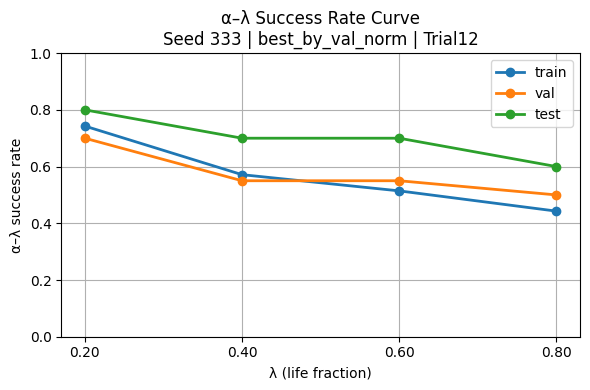

[SAVE] ./Trial12\seed_333\best_by_val_norm\alpha_lambda_eval\alpha_lambda_curve_seed333_best_by_val_norm.png


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# USER CONFIG (Trial12)
# =========================
TRIAL12_DIR = r"./Trial12"
SEED = 333
CKPT = "best_by_val_norm"   # or "last_epoch"

LAM_STRS = ["0.20", "0.40", "0.60", "0.80"]
LAM = [float(x) for x in LAM_STRS]
SPLITS_ORDER = ["train", "val", "test"]

# =========================
# Paths
# =========================
AL_DIR = os.path.join(
    TRIAL12_DIR, f"seed_{SEED}", CKPT, "alpha_lambda_eval"
)
SUMMARY_CSV = os.path.join(
    AL_DIR, f"alpha_lambda_summary_seed{SEED}_{CKPT}.csv"
)
OUT_PNG = os.path.join(
    AL_DIR, f"alpha_lambda_curve_seed{SEED}_{CKPT}.png"
)

# =========================
# Load
# =========================
if not os.path.exists(SUMMARY_CSV):
    raise FileNotFoundError(f"Not found: {SUMMARY_CSV}")

df = pd.read_csv(SUMMARY_CSV)

# =========================
# Plot
# =========================
plt.figure(figsize=(6, 4))

for split in SPLITS_ORDER:
    sub = df[df["split"] == split]
    if sub.empty:
        print(f"[SKIP] no data for split={split}")
        continue

    row = sub.iloc[0]
    rates = []
    for ls in LAM_STRS:
        v = row.get(f"rate_{ls}", np.nan)
        rates.append(float(v) if np.isfinite(v) else np.nan)

    plt.plot(
        LAM,
        rates,
        marker="o",
        linewidth=2,
        label=split
    )

plt.xticks(LAM, [f"{x:.2f}" for x in LAM])
plt.ylim(0.0, 1.0)
plt.xlabel("λ (life fraction)")
plt.ylabel("α–λ success rate")
plt.title(f"α–λ Success Rate Curve\nSeed {SEED} | {CKPT} | Trial12")
plt.grid(True)
plt.legend()
plt.tight_layout()

# =========================
# Save
# =========================
os.makedirs(os.path.dirname(OUT_PNG), exist_ok=True)
plt.savefig(OUT_PNG, dpi=200, bbox_inches="tight")
plt.show()

print(f"[SAVE] {OUT_PNG}")


In [ ]:
import os
from pathlib import Path
from typing import Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# USER CONFIG
# ============================================================
TRIAL_DIR = r"./Trial9"              # Trial9 폴더
SEED = 333                           # seed 선택
CKPT = "best_by_val_norm"            # "best_by_val_norm" or "last_epoch"

SPLITS = ["train", "val", "test"]    # ✅ 여러 split 한 번에

ALPHA = 0.20
SEQ_LEN = 100                        # (참고) eval 구간에서 t_s=seq_len-1을 이미 metrics가 갖고 있어 직접 쓰진 않음
LAMBDA_TO_PLOT = 0.60                # α–λ 그림에 표시할 λ

MAX_FILES = None                     # None=모두, 아니면 예: 10

# 저장 폴더 루트
OUT_ROOT = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT, "paper_figures_bookstyle")

# ============================================================
# Helpers
# ============================================================
def safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")

def load_cycle_seq_and_metrics(seed_dir: str, split: str):
    """
    Trial9가 이미 만들어 둔 파일들:
      - <split>_cycle_sequence_mean.csv
      - <split>_prognostics_metrics_per_file.csv
    """
    seq_csv = os.path.join(seed_dir, f"{split}_cycle_sequence_mean.csv")
    met_csv = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")

    if not os.path.exists(seq_csv):
        raise FileNotFoundError(f"Missing: {seq_csv}")
    if not os.path.exists(met_csv):
        raise FileNotFoundError(f"Missing: {met_csv}")

    df_seq = pd.read_csv(seq_csv)
    df_met = pd.read_csv(met_csv)
    return df_seq, df_met

def get_eval_segment(df_one_file: pd.DataFrame, t_s: int, t_e: int) -> pd.DataFrame:
    df = df_one_file.sort_values("cycle").copy()
    df = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df.reset_index(drop=True, inplace=True)
    return df

# ============================================================
# Plotters
# ============================================================
def plot_ph_alpha_absolute_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    out_path: str,
    ph_start: Optional[float] = None,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(a) 스타일: PH용 α-zone은 '절대 폭(평행 밴드)'
      alphaZone = alpha * EOL_true
      zone = RUL_true ± alphaZone
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    last_cycle = int(df_eval["cycle"].max())
    eol_true = last_cycle + 1

    alpha_zone = alpha * float(eol_true)  # ✅ book-style 핵심 (평행 밴드)
    upper = y_true + alpha_zone
    lower = y_true - alpha_zone

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")
    plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α-zone (±α·EOL)")
    plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α-zone (±α·EOL)")

    if ph_start is not None and np.isfinite(ph_start):
        plt.axvline(int(ph_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α+PH (absolute band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

def plot_alpha_lambda_relative_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(b) 스타일: α–λ는 '상대 폭(수렴 밴드)'
      zone = RUL_true*(1±alpha), 그리고 t >= t_lambda 구간만 표시
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, color="g", linestyle=":", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], "b--", label=f"+{alpha:.2f} α–λ zone")
            plt.plot(x[mask], lower[mask], "b--", label=f"-{alpha:.2f} α–λ zone")
        else:
            plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α–λ (relative band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

# ============================================================
# Main (multi-split)
# ============================================================
def run_for_one_split(seed_dir: str, split: str):
    df_seq, df_met = load_cycle_seq_and_metrics(seed_dir, split)

    files = df_seq["file"].unique().tolist()
    if MAX_FILES is not None:
        files = files[:MAX_FILES]

    out_dir = os.path.join(OUT_ROOT, split)  # ✅ split별 폴더
    os.makedirs(out_dir, exist_ok=True)

    lam_key = f"t_lambda_{LAMBDA_TO_PLOT:.2f}"
    title_prefix = f"SEED {SEED} | {CKPT.upper()} | {split}"

    for f in files:
        sub = df_seq[df_seq["file"] == f].copy()
        mrow = df_met[df_met["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        ph_start = mrow.get("t_PH_start", np.nan)
        t_lambda = mrow.get(lam_key, np.nan)

        df_eval = get_eval_segment(sub, t_s, t_e)
        if df_eval.empty:
            continue

        sname = safe_name(f)

        out_a = os.path.join(out_dir, f"FIG_A_BOOKSTYLE_alpha_PH__{sname}.png")
        plot_ph_alpha_absolute_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            out_path=out_a,
            ph_start=ph_start if np.isfinite(ph_start) else None,
            title_prefix=title_prefix,
        )

        out_b = os.path.join(out_dir, f"FIG_B_BOOKSTYLE_alpha_lambda__lam{LAMBDA_TO_PLOT:.2f}__{sname}.png")
        plot_alpha_lambda_relative_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            lambda_to_plot=LAMBDA_TO_PLOT,
            t_lambda=int(t_lambda) if np.isfinite(t_lambda) else None,
            out_path=out_b,
            title_prefix=title_prefix,
        )

    print(f"[{split}] DONE -> {out_dir}")

def main():
    seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT)

    for split in SPLITS:
        run_for_one_split(seed_dir, split)

    print("\nALL DONE.")
    print("Saved under:", OUT_ROOT)

if __name__ == "__main__":
    main()


In [6]:
import os
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# USER CONFIG (Trial12)
# ============================================================
TRIAL_DIR = r"./Trial12"             # ✅ Trial12 루트 폴더
SEED = 333                           # seed 선택
CKPT = "best_by_val_norm"            # "best_by_val_norm" or "last_epoch"

SPLITS = ["train", "val", "test"]    # ✅ 여러 split 한 번에

ALPHA = 0.20
LAMBDA_TO_PLOT = 0.60                # α–λ 그림에 표시할 λ
MAX_FILES = None                     # None=모두, 아니면 예: 10

# ============================================================
# Paths
# Trial12 구조:
#   ./Trial12/seed_<seed>/<ckpt>/
#       train_cycle_sequence_mean.csv
#       train_prognostics_metrics_per_file.csv
#       ...
# ============================================================
SEED_DIR = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT)

# 저장 폴더 루트 (원하면 이름 바꿔도 됨)
OUT_ROOT = os.path.join(SEED_DIR, "paper_figures_bookstyle")

# ============================================================
# Helpers
# ============================================================
def safe_name(s: str) -> str:
    return s.replace("/", "_").replace("\\", "_").replace(":", "_")


def load_cycle_seq_and_metrics(seed_dir: str, split: str):
    """
    Trial12가 만들어 둔 파일들:
      - <split>_cycle_sequence_mean.csv
      - <split>_prognostics_metrics_per_file.csv
    (Trial12 export_ckpt()가 sub_dir(=seed_dir/tag) 아래에 저장함)
    """
    seq_csv = os.path.join(seed_dir, f"{split}_cycle_sequence_mean.csv")
    met_csv = os.path.join(seed_dir, f"{split}_prognostics_metrics_per_file.csv")

    if not os.path.exists(seq_csv):
        raise FileNotFoundError(f"Missing: {seq_csv}")
    if not os.path.exists(met_csv):
        raise FileNotFoundError(f"Missing: {met_csv}")

    df_seq = pd.read_csv(seq_csv)
    df_met = pd.read_csv(met_csv)
    return df_seq, df_met


def get_eval_segment(df_one_file: pd.DataFrame, t_s: int, t_e: int) -> pd.DataFrame:
    df = df_one_file.sort_values("cycle").copy()
    df = df[(df["cycle"] >= t_s) & (df["cycle"] <= t_e)].copy()
    df.reset_index(drop=True, inplace=True)
    return df


# ============================================================
# Plotters
# ============================================================
def plot_ph_alpha_absolute_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    out_path: str,
    ph_start: Optional[float] = None,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(a) 스타일: PH용 α-zone은 '절대 폭(평행 밴드)'
      alphaZone = alpha * EOL_true
      zone = RUL_true ± alphaZone
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    last_cycle = int(df_eval["cycle"].max())
    eol_true = last_cycle + 1

    alpha_zone = alpha * float(eol_true)  # ✅ book-style 핵심 (평행 밴드)
    upper = y_true + alpha_zone
    lower = y_true - alpha_zone

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")
    plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α-zone (±α·EOL)")
    plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α-zone (±α·EOL)")

    if ph_start is not None and np.isfinite(ph_start):
        plt.axvline(int(ph_start), color="g", linestyle="-.", label="PH start")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α+PH (absolute band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


def plot_alpha_lambda_relative_band(
    df_eval: pd.DataFrame,
    file_name: str,
    alpha: float,
    lambda_to_plot: float,
    t_lambda: Optional[int],
    out_path: str,
    title_prefix: str = "",
):
    """
    BOOK Fig.2.9(b) 스타일: α–λ는 '상대 폭(수렴 밴드)'
      zone = RUL_true*(1±alpha), 그리고 t >= t_lambda 구간만 표시
    """
    os.makedirs(os.path.dirname(out_path), exist_ok=True)

    x = df_eval["cycle"].to_numpy()
    y_true = df_eval["RUL_true"].to_numpy()
    y_pred = df_eval["RUL_pred"].to_numpy()

    upper = y_true * (1.0 + alpha)
    lower = y_true * (1.0 - alpha)

    plt.figure()
    plt.plot(x, y_true, "k", label="True (cycles)")
    plt.plot(x, y_pred, "r", label="Prediction (cycles)")

    if t_lambda is not None and np.isfinite(t_lambda):
        t_lambda = int(t_lambda)
        plt.axvline(t_lambda, color="g", linestyle=":", label=f"t_λ (λ={lambda_to_plot:.2f})")

        mask = x >= t_lambda
        if np.any(mask):
            plt.plot(x[mask], upper[mask], "b--", label=f"+{alpha:.2f} α–λ zone")
            plt.plot(x[mask], lower[mask], "b--", label=f"-{alpha:.2f} α–λ zone")
        else:
            plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
            plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")
    else:
        plt.plot(x, upper, "b--", label=f"+{alpha:.2f} α zone")
        plt.plot(x, lower, "b--", label=f"-{alpha:.2f} α zone")

    plt.xlabel("Cycle")
    plt.ylabel("RUL (cycles)")
    plt.title(f"{title_prefix} | BOOK-STYLE α–λ (relative band)\n{file_name}")
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()


# ============================================================
# Main (multi-split)
# ============================================================
def run_for_one_split(seed_dir: str, split: str):
    df_seq, df_met = load_cycle_seq_and_metrics(seed_dir, split)

    files = df_seq["file"].unique().tolist()
    if MAX_FILES is not None:
        files = files[:MAX_FILES]

    out_dir = os.path.join(OUT_ROOT, split)  # ✅ split별 폴더
    os.makedirs(out_dir, exist_ok=True)

    lam_key = f"t_lambda_{LAMBDA_TO_PLOT:.2f}"
    title_prefix = f"SEED {SEED} | {CKPT.upper()} | {split} | Trial12"

    for f in files:
        sub = df_seq[df_seq["file"] == f].copy()
        mrow = df_met[df_met["file"] == f]
        if mrow.empty:
            continue
        mrow = mrow.iloc[0].to_dict()

        t_s = int(mrow["t_s"])
        t_e = int(mrow["t_e"])
        ph_start = mrow.get("t_PH_start", np.nan)
        t_lambda = mrow.get(lam_key, np.nan)

        df_eval = get_eval_segment(sub, t_s, t_e)
        if df_eval.empty:
            continue

        sname = safe_name(f)

        out_a = os.path.join(out_dir, f"FIG_A_BOOKSTYLE_alpha_PH__{sname}.png")
        plot_ph_alpha_absolute_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            out_path=out_a,
            ph_start=ph_start if np.isfinite(ph_start) else None,
            title_prefix=title_prefix,
        )

        out_b = os.path.join(out_dir, f"FIG_B_BOOKSTYLE_alpha_lambda__lam{LAMBDA_TO_PLOT:.2f}__{sname}.png")
        plot_alpha_lambda_relative_band(
            df_eval=df_eval,
            file_name=f,
            alpha=ALPHA,
            lambda_to_plot=LAMBDA_TO_PLOT,
            t_lambda=int(t_lambda) if np.isfinite(t_lambda) else None,
            out_path=out_b,
            title_prefix=title_prefix,
        )

    print(f"[{split}] DONE -> {out_dir}")


def main():
    if not os.path.isdir(SEED_DIR):
        raise FileNotFoundError(f"Not found: {SEED_DIR}")

    # split별 실행
    for split in SPLITS:
        run_for_one_split(SEED_DIR, split)

    print("\nALL DONE.")
    print("Saved under:", OUT_ROOT)


if __name__ == "__main__":
    main()


[train] DONE -> ./Trial12\seed_333\best_by_val_norm\paper_figures_bookstyle\train
[val] DONE -> ./Trial12\seed_333\best_by_val_norm\paper_figures_bookstyle\val
[test] DONE -> ./Trial12\seed_333\best_by_val_norm\paper_figures_bookstyle\test

ALL DONE.
Saved under: ./Trial12\seed_333\best_by_val_norm\paper_figures_bookstyle


In [9]:
# ============================================================
# ERROR-FOCUSED XAI / FORENSIC DEBUG (Trial12)
# Goal:
#  - "왜 틀리는지"를 window-level로 규명
#
# What it does:
#  (1) High-error vs Low-error window 그룹을 만들고
#  (2) raw min_vce / raw d_min_vce 파형 비교 (mean±std, exemplar overlay)
#  (3) window 통계량 비교 (noise/variance/slope/monotonicity 등)
#  (4) 어떤 파일/구간에서 에러가 집중되는지 (file ranking)
#  (5) (옵션) high-error window와 "비슷한 cycle의 low-error window"를 매칭해서
#      contrastive(쌍 비교) 파형을 저장
#
# Outputs:
#  Trial12/seed_<seed>/<ckpt>/xai_error_focused/<split>/
#    - 01_group_summary.csv
#    - 02_window_stats_high.csv / 02_window_stats_low.csv
#    - 03_file_error_ranking.csv
#    - 10_meanstd_min_vce.png / 11_meanstd_d_min_vce.png
#    - 12_exemplars_min_vce.png / 13_exemplars_d_min_vce.png
#    - 20_pair_examples/PAIR_*.png   (contrastive pairs)
# ============================================================

import os
import math
from pathlib import Path
from typing import Dict, Tuple, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# ----------------------------
# USER CONFIG (Trial12)
# ----------------------------
DATA_DIR   = r"C:\Users\11HOME_AHCI\Desktop\PoF\Winter 2026\Ref Data4\100"

TRIAL_DIR  = r"./Trial12"          # ✅ Trial12 폴더
SEED       = 333
CKPT_TAG   = "best_by_val_norm"    # or "last_epoch"
SPLIT      = "test"                # "train"/"val"/"test"

SEQ_LEN      = 100
PRED_HORIZON = 0

# 그룹 정의
ERROR_MODE = "quantile"     # "quantile" or "fixed"
HIGH_Q = 0.90               # 상위 10%를 high-error
LOW_Q  = 0.10               # 하위 10%를 low-error
ERROR_FIXED = 300.0         # ERROR_MODE="fixed"일 때 (cycles)

# 샘플링/플롯
N_EXEMPLARS_PER_GROUP = 30         # exemplar overlay 개수
N_PAIRS_TO_SAVE = 30               # high-error window에 대해 low-error 매칭 pair 저장 개수
PAIR_CYCLE_TOL = 200               # 같은 파일 내 cycle 차이 허용(대략 비슷한 stage 비교)

# 저장 폴더
OUT_DIR = os.path.join(TRIAL_DIR, f"seed_{SEED}", CKPT_TAG, "xai_error_focused", SPLIT)
PAIR_DIR = os.path.join(OUT_DIR, "20_pair_examples")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(PAIR_DIR, exist_ok=True)

print("OUT_DIR:", OUT_DIR)


# ============================================================
# Helpers: load predictions_windows.csv
# ============================================================
seed_dir = os.path.join(TRIAL_DIR, f"seed_{SEED}")
sub_dir = os.path.join(seed_dir, CKPT_TAG)

win_csv = os.path.join(sub_dir, f"{SPLIT}_predictions_windows.csv")
if not os.path.exists(win_csv):
    raise FileNotFoundError(f"Missing windows prediction CSV: {win_csv}")

dfw = pd.read_csv(win_csv)
need_cols = ["file", "start_idx", "cycle", "RUL_true", "RUL_pred"]
for c in need_cols:
    if c not in dfw.columns:
        raise ValueError(f"windows CSV missing column: {c}")

dfw["abs_err"] = np.abs(dfw["RUL_pred"].values - dfw["RUL_true"].values)
dfw["signed_err"] = (dfw["RUL_pred"].values - dfw["RUL_true"].values)
print("Loaded windows:", len(dfw))


# ============================================================
# Helpers: raw signal access
# ============================================================
_raw_cache: Dict[str, Tuple[np.ndarray, np.ndarray]] = {}

def load_raw_file(file_name: str) -> Tuple[np.ndarray, np.ndarray]:
    """returns (vce, rul) raw arrays"""
    if file_name in _raw_cache:
        return _raw_cache[file_name]
    path = Path(DATA_DIR) / file_name
    if not path.exists():
        raise FileNotFoundError(f"Missing raw CSV: {path}")
    df = pd.read_csv(path, header=None)
    vce = df.iloc[:, 0].astype(np.float32).to_numpy()
    rul = df.iloc[:, 1].astype(np.float32).to_numpy()
    _raw_cache[file_name] = (vce, rul)
    return vce, rul

def compute_dvce(vce: np.ndarray) -> np.ndarray:
    dv = np.zeros_like(vce, dtype=np.float32)
    dv[1:] = vce[1:] - vce[:-1]
    return dv

def get_window_raw(file_name: str, start_idx: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    returns:
      min_vce_window (SEQ_LEN,)
      d_min_vce_window (SEQ_LEN,)
    """
    vce, _rul = load_raw_file(file_name)
    s = int(start_idx)
    e = s + SEQ_LEN
    if e > len(vce):
        raise IndexError(f"Window out of range: {file_name}, s={s}, e={e}, T={len(vce)}")
    w = vce[s:e].astype(np.float32)
    dv = compute_dvce(vce)[s:e].astype(np.float32)
    return w, dv


# ============================================================
# 1) Define high/low error groups
# ============================================================
if ERROR_MODE == "quantile":
    thr_high = float(dfw["abs_err"].quantile(HIGH_Q))
    thr_low  = float(dfw["abs_err"].quantile(LOW_Q))
else:
    thr_high = float(ERROR_FIXED)
    thr_low  = float(ERROR_FIXED)  # fixed 모드면 low는 별도 정의가 애매해서 동일 임계값 사용

df_high = dfw[dfw["abs_err"] >= thr_high].copy()
df_low  = dfw[dfw["abs_err"] <= thr_low].copy()

print(f"High group: n={len(df_high)} (thr_high={thr_high:.3f})")
print(f"Low  group: n={len(df_low)} (thr_low ={thr_low:.3f})")

# group summary
summary_rows = [{
    "mode": ERROR_MODE,
    "thr_high": thr_high,
    "thr_low": thr_low,
    "n_total": len(dfw),
    "n_high": len(df_high),
    "n_low": len(df_low),
    "mean_abs_err_total": float(dfw["abs_err"].mean()),
    "mean_abs_err_high": float(df_high["abs_err"].mean()) if len(df_high) else np.nan,
    "mean_abs_err_low":  float(df_low["abs_err"].mean())  if len(df_low)  else np.nan,
    "mean_signed_err_high": float(df_high["signed_err"].mean()) if len(df_high) else np.nan,
    "mean_signed_err_low":  float(df_low["signed_err"].mean())  if len(df_low)  else np.nan,
}]
pd.DataFrame(summary_rows).to_csv(os.path.join(OUT_DIR, "01_group_summary.csv"), index=False)


# ============================================================
# 2) Window-level statistics (raw signal forensic)
# ============================================================
def window_stats(w_min_vce: np.ndarray, w_dvce: np.ndarray) -> Dict[str, float]:
    """
    PHM 관점에서 '왜 틀리는지' 후보를 잡는 통계량들
    """
    # min_vce stats
    v_mean = float(np.mean(w_min_vce))
    v_std  = float(np.std(w_min_vce))
    v_rng  = float(np.max(w_min_vce) - np.min(w_min_vce))
    v_slope = float((w_min_vce[-1] - w_min_vce[0]) / max(len(w_min_vce)-1, 1))

    # dvce stats
    d_mean = float(np.mean(w_dvce))
    d_std  = float(np.std(w_dvce))
    d_abs_mean = float(np.mean(np.abs(w_dvce)))
    d_abs_max  = float(np.max(np.abs(w_dvce)))

    # rough monotonicity score (min_vce)
    diff = np.diff(w_min_vce)
    mono = float(np.mean(diff >= 0.0))  # 증가 비율(0~1)

    # spike ratio (dvce)
    # "dvce가 과하게 튀는 window는 모델이 헷갈릴 가능성"
    denom = (d_std + 1e-12)
    spike_ratio = float(d_abs_max / denom)

    return {
        "min_vce_mean": v_mean,
        "min_vce_std": v_std,
        "min_vce_range": v_rng,
        "min_vce_slope": v_slope,
        "min_vce_monotonicity": mono,
        "dvce_mean": d_mean,
        "dvce_std": d_std,
        "dvce_abs_mean": d_abs_mean,
        "dvce_abs_max": d_abs_max,
        "dvce_spike_ratio": spike_ratio,
    }

def build_stats_df(df_group: pd.DataFrame, max_rows: int = 5000, seed: int = 0) -> pd.DataFrame:
    df = df_group.copy()
    if len(df) > max_rows:
        df = df.sample(n=max_rows, random_state=seed)

    rows = []
    for _, r in df.iterrows():
        f = str(r["file"])
        s = int(r["start_idx"])
        try:
            wv, wd = get_window_raw(f, s)
            st = window_stats(wv, wd)
            st.update({
                "file": f,
                "start_idx": s,
                "cycle": int(r["cycle"]),
                "abs_err": float(r["abs_err"]),
                "signed_err": float(r["signed_err"]),
                "RUL_true": float(r["RUL_true"]),
                "RUL_pred": float(r["RUL_pred"]),
            })
            rows.append(st)
        except Exception as e:
            # window out-of-range 등 예외 방어
            continue

    return pd.DataFrame(rows)

df_high_stats = build_stats_df(df_high, max_rows=5000, seed=0)
df_low_stats  = build_stats_df(df_low,  max_rows=5000, seed=1)

df_high_stats.to_csv(os.path.join(OUT_DIR, "02_window_stats_high.csv"), index=False)
df_low_stats.to_csv(os.path.join(OUT_DIR, "02_window_stats_low.csv"), index=False)

print("Saved stats:",
      os.path.join(OUT_DIR, "02_window_stats_high.csv"),
      os.path.join(OUT_DIR, "02_window_stats_low.csv"))


# ============================================================
# 3) File ranking: 에러가 특정 파일에 몰리는지
# ============================================================
file_rank = dfw.groupby("file", as_index=False).agg(
    n_windows=("abs_err", "count"),
    mean_abs_err=("abs_err", "mean"),
    p90_abs_err=("abs_err", lambda x: float(np.quantile(x, 0.90))),
    max_abs_err=("abs_err", "max"),
).sort_values("mean_abs_err", ascending=False)

file_rank.to_csv(os.path.join(OUT_DIR, "03_file_error_ranking.csv"), index=False)


# ============================================================
# 4) Plot: High vs Low mean±std trajectories (raw)
# ============================================================
def sample_windows(df_group: pd.DataFrame, n: int, seed: int) -> List[Tuple[str,int]]:
    if df_group.empty:
        return []
    df_s = df_group.sample(n=min(n, len(df_group)), random_state=seed)
    return [(str(r["file"]), int(r["start_idx"])) for _, r in df_s.iterrows()]

def collect_windows(pairs: List[Tuple[str,int]]) -> Tuple[np.ndarray, np.ndarray]:
    Wv, Wd = [], []
    for f,s in pairs:
        try:
            wv, wd = get_window_raw(f, s)
            Wv.append(wv)
            Wd.append(wd)
        except Exception:
            pass
    if len(Wv) == 0:
        raise ValueError("No windows collected for plotting.")
    return np.stack(Wv, axis=0), np.stack(Wd, axis=0)

high_pairs = sample_windows(df_high, n=2000, seed=0)
low_pairs  = sample_windows(df_low,  n=2000, seed=1)

Wv_h, Wd_h = collect_windows(high_pairs)
Wv_l, Wd_l = collect_windows(low_pairs)

t = np.arange(SEQ_LEN)

def plot_meanstd(title: str, y_h: np.ndarray, y_l: np.ndarray, ylabel: str, out_path: str) -> None:
    # y_* shape: (N, T)
    m_h = np.mean(y_h, axis=0); s_h = np.std(y_h, axis=0)
    m_l = np.mean(y_l, axis=0); s_l = np.std(y_l, axis=0)

    plt.figure()
    plt.plot(t, m_h, label="High-error mean")
    plt.fill_between(t, m_h - s_h, m_h + s_h, alpha=0.2)

    plt.plot(t, m_l, label="Low-error mean")
    plt.fill_between(t, m_l - s_l, m_l + s_l, alpha=0.2)

    plt.title(title)
    plt.xlabel("t in window")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

plot_meanstd(
    title=f"High vs Low Error | mean±std | min_vce (raw) | {SPLIT}",
    y_h=Wv_h, y_l=Wv_l,
    ylabel="min_vce",
    out_path=os.path.join(OUT_DIR, "10_meanstd_min_vce.png")
)
plot_meanstd(
    title=f"High vs Low Error | mean±std | d_min_vce (raw) | {SPLIT}",
    y_h=Wd_h, y_l=Wd_l,
    ylabel="d_min_vce",
    out_path=os.path.join(OUT_DIR, "11_meanstd_d_min_vce.png")
)

print("Saved mean±std plots.")


# ============================================================
# 5) Plot: Exemplars overlay (raw)
# ============================================================
def plot_exemplars(df_group: pd.DataFrame, n: int, seed: int, mode: str, out_path: str, which: str):
    if df_group.empty:
        return
    df_s = df_group.sample(n=min(n, len(df_group)), random_state=seed)

    plt.figure()
    for _, r in df_s.iterrows():
        f = str(r["file"]); s = int(r["start_idx"])
        try:
            wv, wd = get_window_raw(f, s)
            y = wv if which == "min_vce" else wd
            plt.plot(t, y, alpha=0.25)
        except Exception:
            continue

    plt.title(f"{mode} exemplars overlay | {which} (raw) | {SPLIT}")
    plt.xlabel("t in window")
    plt.ylabel(which)
    plt.grid(True)
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

plot_exemplars(df_high, N_EXEMPLARS_PER_GROUP, 0, "High-error", os.path.join(OUT_DIR, "12_exemplars_min_vce.png"), "min_vce")
plot_exemplars(df_high, N_EXEMPLARS_PER_GROUP, 0, "High-error", os.path.join(OUT_DIR, "13_exemplars_d_min_vce.png"), "d_min_vce")
plot_exemplars(df_low,  N_EXEMPLARS_PER_GROUP, 1, "Low-error",  os.path.join(OUT_DIR, "14_exemplars_min_vce.png"), "min_vce")
plot_exemplars(df_low,  N_EXEMPLARS_PER_GROUP, 1, "Low-error",  os.path.join(OUT_DIR, "15_exemplars_d_min_vce.png"), "d_min_vce")

print("Saved exemplar overlays.")


# ============================================================
# 6) Contrastive Pairs: high-error window와 "같은 파일에서 비슷한 cycle" low-error window 매칭
# ============================================================
# low 그룹을 파일별로 인덱싱해두면 빠르게 매칭 가능
low_by_file: Dict[str, pd.DataFrame] = {}
for f, sub in df_low.groupby("file"):
    low_by_file[str(f)] = sub.copy().sort_values("cycle")

def find_low_match(file_name: str, cycle: int, tol: int) -> Dict:
    """
    같은 파일 내에서 cycle이 비슷한 low-error window를 찾는다.
    """
    if file_name not in low_by_file:
        return {}
    sub = low_by_file[file_name]
    # cycle 차이 최소
    idx = np.argmin(np.abs(sub["cycle"].values - int(cycle)))
    cand = sub.iloc[int(idx)].to_dict()
    if abs(int(cand["cycle"]) - int(cycle)) <= tol:
        return cand
    return {}

df_high_sorted = df_high.sort_values("abs_err", ascending=False).copy()
saved = 0

for _, r in df_high_sorted.iterrows():
    if saved >= N_PAIRS_TO_SAVE:
        break
    f = str(r["file"])
    cyc = int(r["cycle"])
    match = find_low_match(f, cyc, PAIR_CYCLE_TOL)
    if not match:
        continue

    s_hi = int(r["start_idx"])
    s_lo = int(match["start_idx"])

    try:
        v_hi, d_hi = get_window_raw(f, s_hi)
        v_lo, d_lo = get_window_raw(f, s_lo)
    except Exception:
        continue

    # pair plot
    plt.figure(figsize=(10,6))
    plt.subplot(2,1,1)
    plt.plot(t, v_hi, label=f"HIGH (abs_err={float(r['abs_err']):.1f}, cycle={cyc}, s={s_hi})")
    plt.plot(t, v_lo, label=f"LOW  (abs_err={float(match['abs_err']):.1f}, cycle={int(match['cycle'])}, s={s_lo})")
    plt.title(f"PAIR {saved+1:02d} | file={f} | min_vce (raw)")
    plt.xlabel("t in window"); plt.ylabel("min_vce"); plt.grid(True); plt.legend()

    plt.subplot(2,1,2)
    plt.plot(t, d_hi, label="HIGH d_min_vce")
    plt.plot(t, d_lo, label="LOW  d_min_vce")
    plt.xlabel("t in window"); plt.ylabel("d_min_vce"); plt.grid(True); plt.legend()

    safe_f = f.replace("/", "_").replace("\\", "_")

    outp = os.path.join(
        PAIR_DIR,
        f"PAIR_{saved+1:02d}__{safe_f}__cycle{cyc}.png"
    )
    plt.tight_layout()
    plt.savefig(outp, dpi=200, bbox_inches="tight")
    plt.close()

    saved += 1

print(f"Saved contrastive pairs: {saved}/{N_PAIRS_TO_SAVE}")
print("\n[DONE] Error-focused forensic pack saved to:", OUT_DIR)


OUT_DIR: ./Trial12\seed_333\best_by_val_norm\xai_error_focused\test
Loaded windows: 8621
High group: n=863 (thr_high=3065.911)
Low  group: n=863 (thr_low =53.252)
Saved stats: ./Trial12\seed_333\best_by_val_norm\xai_error_focused\test\02_window_stats_high.csv ./Trial12\seed_333\best_by_val_norm\xai_error_focused\test\02_window_stats_low.csv
Saved mean±std plots.
Saved exemplar overlays.
Saved contrastive pairs: 30/30

[DONE] Error-focused forensic pack saved to: ./Trial12\seed_333\best_by_val_norm\xai_error_focused\test
